# Workshop on Speech Perception, Part 1: Probing acoustic, phonemic and orthographic information in Wav2Vec2

*Interpretability & Explainability in AI, MSc A.I., University of Amsterdam, June 2024*

This notebook includes contributions by: Marianne de Heer Kloots, Marta Grasa & Charlotte Pouw.

## Probing Audio models

In Week 1, you trained probes on the hidden states of a fine-tuned RoBERTa model, to gain insights into how sentiment is represented in this model across layers. In this notebook, you will perform similar analyses on an **audio-based Transformer model: Wav2Vec2**. This self-supervised model learns powerful representations of speech from raw audio data and can be applied to many downstream tasks, including **Automatic Speech Recognition (ASR)** — the conversion from spoken language audio signals into text transcriptions.

Before the rise of deep learning, ASR was performed using a pipeline of different components, each performing a subpart of the task. The ASR pipeline included the following steps:

1.   **Feature extraction**: extracting relevant time-frequency information from the raw audio signal.
2.   **Acoustic modelling**: mapping the extracted audio features to a sequence of [phonemes](https://en.wikipedia.org/wiki/Phoneme), the smallest meaningful units in speech. **<a name="cite_ref-1"></a>[<sup>[1]</sup>](#cite_note-1)**
3.   **Language modelling**: mapping the sequence of phonemes to a sequence of written words.

Self-supervised speech models such as Wav2Vec2 are able to perform all of the above steps in an **end-to-end** fashion. In this assignment, we will evaluate the model's output performance on text transcription at the output layer as well as earlier layers, and we will compare this to the implicit encoding of other representations relevant to the ASR task, such as phonemes.

<a name="cite_note-1"></a>**[[1^](#cite_ref-1)]** **_Phonemes_** are abstractions over speech sound variations — called _(allo)phones_ — that are perceived as the same sound by native speakers of a language. For example, the **/t/** phoneme in English is pronounced slightly differently at the start of a word vs. when it's preceded by other consonants: \<tone\> [tʰoʊn] starts with the _aspirated_ allophone [tʰ], whereas \<stone\> [stoʊn] includes the _unaspirated_ allophone [t] (see [this page](https://aminoapps.com/c/language-exchange/page/blog/a-sketch-on-vot/J86a_gGRcduQ5dneg03ZaznxdR20gVY10Q) for some visualizations). Phonetic transcriptions, written [bɪtʰwi:n skwɛəɹ bɹækʰɪts], capture such differences, whereas phonemic transcriptions, written /bɪtwin slæʃɪs/, only use the restricted set of symbols within a language's [phonological inventory](https://phoible.org/) — i.e., its _phonemes_. On the other hand, phonemes do refer to _pronunciations_, and do not necessarily match with orthographic characters. For example, the words \<fit\>, \<phone\>, and \<laugh\> all contain the same phoneme: /f/. Since this phoneme is written in several different ways (\<f\>, \<ph\>, \<gh\>), it can be useful for an ASR model to have (or learn) representations of phonemes at an intermediate stage between the audio signal and its text transcription. (As you may have noticed, orthographic transcriptions are written \<between angle brackets\>.)

In [1]:
# @title Some helper functions
phoneme_mapping = {
    'p': 'p',
    'b': 'b',
    't': 't',
    'd': 'd',
    'k': 'k',
    'g': 'g',
    'dx': 'dx',
    'f': 'f',
    'v': 'v',
    'dh': 'dh',
    'th': 'th',
    's': 's',
    'z': 'z',
    'r': 'r',
    'q': 'q',
    'w': 'w',
    'y': 'y',
    'jh': 'jh',
    'ch': 'ch',
    'iy': 'iy',
    'eh': 'eh',
    'ey': 'ey',
    'ae': 'ae',
    'aw': 'aw',
    'ay': 'ay',
    'oy': 'oy',
    'ow': 'ow',
    'uh': 'uh',
    'ah': 'ah',
    'ax': 'ah',
    'ax-h': 'ah',
    'aa': 'aa',
    'ao': 'aa',
    'er': 'er',
    'axr': 'er',
    'hh': 'hh',
    'hv': 'hh',
    'ih': 'ih',
    'ix': 'ih',
    'l': 'l',
    'el': 'l',
    'm': 'm',
    'em': 'm',
    'n': 'n',
    'en': 'n',
    'nx': 'n',
    'ng': 'ng',
    'eng': 'ng',
    'sh': 'sh',
    'zh': 'sh',
    'uw': 'uw',
    'ux': 'uw',
    'pcl': 'sil',
    'bcl': 'sil',
    'tcl': 'sil',
    'dcl': 'sil',
    'kcl': 'sil',
    'gcl': 'sil',
    'h#': 'sil',
    'pau': 'sil',
    'epi': 'sil'
}

def convert_phon_utterance(example, phoneme_mapping=phoneme_mapping):
  """
  Map phonetic annotations to a smaller set of phonemes (defined in the phoneme_mapping dict).
  """
  utterance = example['phonetic_detail']['utterance']
  new_utterance = [phoneme_mapping[phone] for phone in utterance]
  example['phonetic_detail']['utterance'] = new_utterance
  return example

def set_seed(seed):
    """Set random seed."""
    if seed == -1:
        seed = random.randint(0, 1000)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)

    # if you are using GPU
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.enabled = False
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

def filter_timit_data(timit_split, N_speakers):
  SX_sentences = timit_split.filter(lambda x: x['sentence_type'] == 'SX')
  sentence_subset = [t for t, c in pd.Series(SX_sentences['text']).value_counts().items() if c == 7]
  timit_split = timit_split.filter(lambda x: x["text"] in sentence_subset)
  speaker_subset = [s for s, c in pd.Series(timit_split['speaker_id']).value_counts().items() if c == 5]
  male_speakers = [s for s in speaker_subset if s[0] == 'M']
  female_speakers = [s for s in speaker_subset if s[0] == 'F']
  balanced_N_speakers = min(len(male_speakers), len(female_speakers), N_speakers//2)
  male_speakers = list(np.random.choice(male_speakers, size=balanced_N_speakers, replace=False))
  female_speakers = list(np.random.choice(female_speakers, size=balanced_N_speakers, replace=False))
  speaker_subset = male_speakers + female_speakers
  timit_split = timit_split.filter(lambda x: x["speaker_id"] in speaker_subset)
  return timit_split

def create_timit_subset(full_timit_dataset, train_speakers=60, test_speakers=24):
  phon_converted_timit = full_timit_dataset.map(convert_phon_utterance).rename_column("phonetic_detail", "phonemic_detail")
  timit_subset_train = filter_timit_data(phon_converted_timit['train'], N_speakers=train_speakers)
  timit_subset_test = filter_timit_data(phon_converted_timit['test'], N_speakers=test_speakers)
  timit_subset = DatasetDict({"train": timit_subset_train, "test": timit_subset_test})
  return timit_subset

def plot_audio_annotations(raw_waveform, envelope, envelope_timepoints, word_start_times, word_end_times, words, phoneme_start_times, phoneme_end_times, phonemes, sampling_rate):
  fig, axs = plt.subplots(4, 1, figsize=(30,7.5), sharex=True, gridspec_kw={'height_ratios': [1, 1, .25, .25]})
  librosa.display.waveshow(raw_waveform, sr=sampling_rate, alpha=0.4, ax=axs[0])
  axs[0].plot(envelope_timepoints, envelope, color='red')
  axs[0].set_xlabel('')
  axs[0].set_xlim(0, len(raw_waveform)/sampling_rate)
  axs[0].tick_params(axis='y', which='major', labelsize=12)
  D = librosa.stft(raw_waveform)
  S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
  librosa.display.specshow(S_db, ax=axs[1], y_axis='log', x_axis='time', sr=sampling_rate)
  for i, word in enumerate(words):
    start_time = word_start_times[i]
    end_time = word_end_times[i]
    word_position = ((start_time + end_time) / 2)
    axs[2].text(word_position, .45, word, fontweight='bold', ha='center', size=12)
    axs[2].axvline(start_time, color='grey')
    axs[2].axvline(end_time, color='grey')
    axs[2].set_ylabel('words', size=15, rotation=0, va='center', ha='right')
    axs[2].set_yticks([])
  for i, phoneme in enumerate(phonemes):
    start_time = phoneme_start_times[i]
    end_time = phoneme_end_times[i]
    phoneme_position = ((start_time + end_time) / 2)
    axs[3].text(phoneme_position, .45, phoneme, fontweight='bold', ha='center', size=12)
    axs[3].axvline(start_time, color='grey')
    axs[3].axvline(end_time, color='grey')
    axs[3].set_ylabel('phonemes', size=15, rotation=0, va='center', ha='right')
    axs[3].set_yticks([])
  plt.subplots_adjust(wspace=0, hspace=0)
  plt.xlabel("Time (s)", size=15)
  plt.tick_params(axis='x', which='major', labelsize=15)
  plt.show()

### Configuration

Don't forget to enable the GPU runtime at the top! (Runtime -> Change runtime type)

Install and import packages:

In [2]:
%%capture
# we need an older version of the datasets library for loading the TIMIT dataset
!pip install -q datasets==1.18.3 transformers jiwer

In [49]:
import torch
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC
from datasets import load_dataset, load_metric, DatasetDict
import jiwer
from jiwer import wer, cer
import librosa
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import random
import string
import matplotlib.pyplot as plt
import IPython.display as ipd
import warnings
from collections import Counter
import gc
from tqdm import *

Connect to the GPU:

In [7]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

cuda


Set a random seed:

In [5]:
set_seed(42)

## The TIMIT dataset

We will use the [TIMIT Acoustic-Phonetic Continuous Speech Corpus](https://catalog.ldc.upenn.edu/LDC93S1), which contains sentence recordings of 630 speakers of eight major American-English dialects. Each speaker read aloud ten sentences, which were designed to elicit a wide variety of speech sounds. The corpus includes time-aligned transcriptions, as well as the raw waveform for each spoken sentence, sampled at a rate of 16 kHz.

In this notebook we'll work with an adjusted subset of the TIMIT corpus, using only the 'phonetically compact' (SX) sentences (see the [TIMIT README](https://catalog.ldc.upenn.edu/docs/LDC93S1/timit.readme.html) for details), and a subset of 84 speakers in total (60 in our train set, 24 in our test set), where the number of recordings is balanced for speaker sex and id.

##### <input type="checkbox"/> <font color='green'>**ToDo 1**</font>: TIMIT data

Load the TIMIT corpus and our filtered subset by running the cell below.

Explore some examples in the train set: what does the audio signal look like?

In [6]:
# load & preprocess our TIMIT subset
timit = load_dataset("timit_asr", "clean")
timit_subset = create_timit_subset(timit)

# remove the original TIMIT dataset
del timit
gc.collect()

Downloading:   0%|          | 0.00/2.40k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/869M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset timit_asr downloaded and prepared to /root/.cache/huggingface/datasets/timit_asr/clean/2.0.1/b11b576ddcccbcefa7c9f0c4e6c2a43756f3033adffe0fb686aa61043d0450ad. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

250

##### <input type="checkbox"/> <font color='blue'>**ToThink 1**</font>: Audio visualizations

Look at the example below, which visualizes one recording out of the TIMIT subset, and try to understand it (open the image in a separate browser tab if you want to zoom in). This plot includes two visualizations of the audio signal: on top, the raw audio waveform in blue, with its (upper) [amplitude envelope](https://upload.wikimedia.org/wikipedia/commons/3/31/Signal_envelopes.png) in red, and below it, the [spectrogram](https://en.wikipedia.org/wiki/Spectrogram). Although Wav2Vec2 takes the raw waveform as input, some speech models (such as Whisper) work based on derived features more like the spectrogram.

Make sure you know on a general level how to read these visualizations: what is on the y-axis of the waveform plot? What do the colors in the spectrogram plot mean?

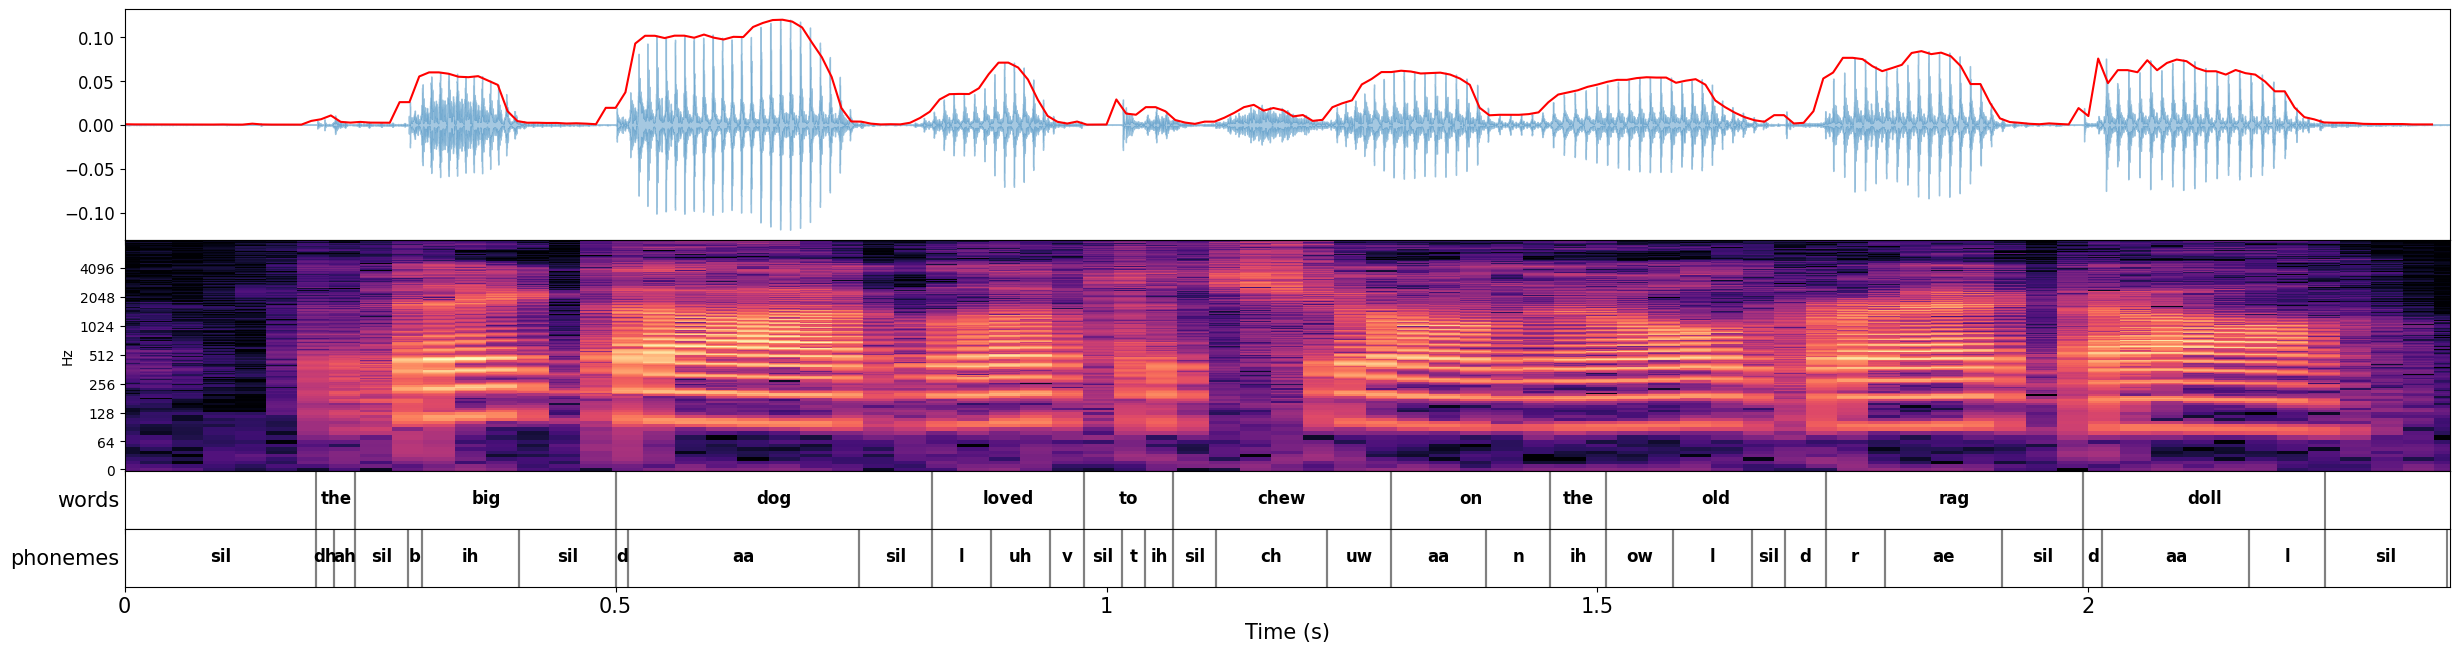

##### <input type="checkbox"/> <font color='green'>**ToDo 2**</font>: Amplitude envelope
To familiarize ourselves with audio data, we will compute the amplitude envelope ourselves. This is a very basic acoustic feature over the audio signal tracking the upper contour of the raw waveform, but nonetheless forms a useful basis for example for analyses of [speech rhythm](https://doi.org/10.1121/1.4807565). Here, we will approximate the amplitude envelope by taking the maximum value over a sliding window throughout the waveform.

In [11]:
## TODO: complete the function below for computing the amplitude envelope over the waveform

def amplitude_envelope(audio_signal, sampling_rate, window_length=200, hop_length=160):
    """
    Compute the amplitude envelope for a given audio_signal using a sliding window.
    """
    signal_envelope = []

    # omit the last frame
    window_starts = range(0, len(audio_signal), hop_length)[:-1]

    for start in window_starts:
        # select the current window
        current_window = audio_signal[start:start + window_length]

        # compute the maximum amplitude value in the current window
        envelope_value = max(current_window)

        # append the maximum amplitude to the envelope array
        signal_envelope.append(envelope_value)

    idx = range(0, len(signal_envelope))
    envelope_timepoints = librosa.frames_to_time(idx, sr=sampling_rate, hop_length=hop_length)

    return np.array(signal_envelope), envelope_timepoints

##### <input type="checkbox"/> <font color='red'>**ToSubmit 1**</font>: Visualizing a TIMIT example
Now, we'll recreate the visualizations above for another example out of our TIMIT subset. Retrieve all needed data for this example from `timit_subset['train']` and include the resulting plot below in your report, together with the correct transcription provided in the dataset, and a transcription generated by Wav2Vec2 (we will do this in the next step below). You can simply save and downsize the image below to the page width of your report; don't worry to much about readability for this plot.

Tip: Some details are available on the [`timit_asr` Dataset Card](https://huggingface.co/datasets/timit-asr/timit_asr) on HuggingFace. For our subset, we have replaced the `phonetic_detail` column by a `phonemic_detail` one, where the original transcriptions are mapped to a smaller set (following [Lee & Hon '89](https://doi.org/10.1109/29.46546); see the phoneme_mapping dictionary for details).

Text: A huge power outage rarely occurs.


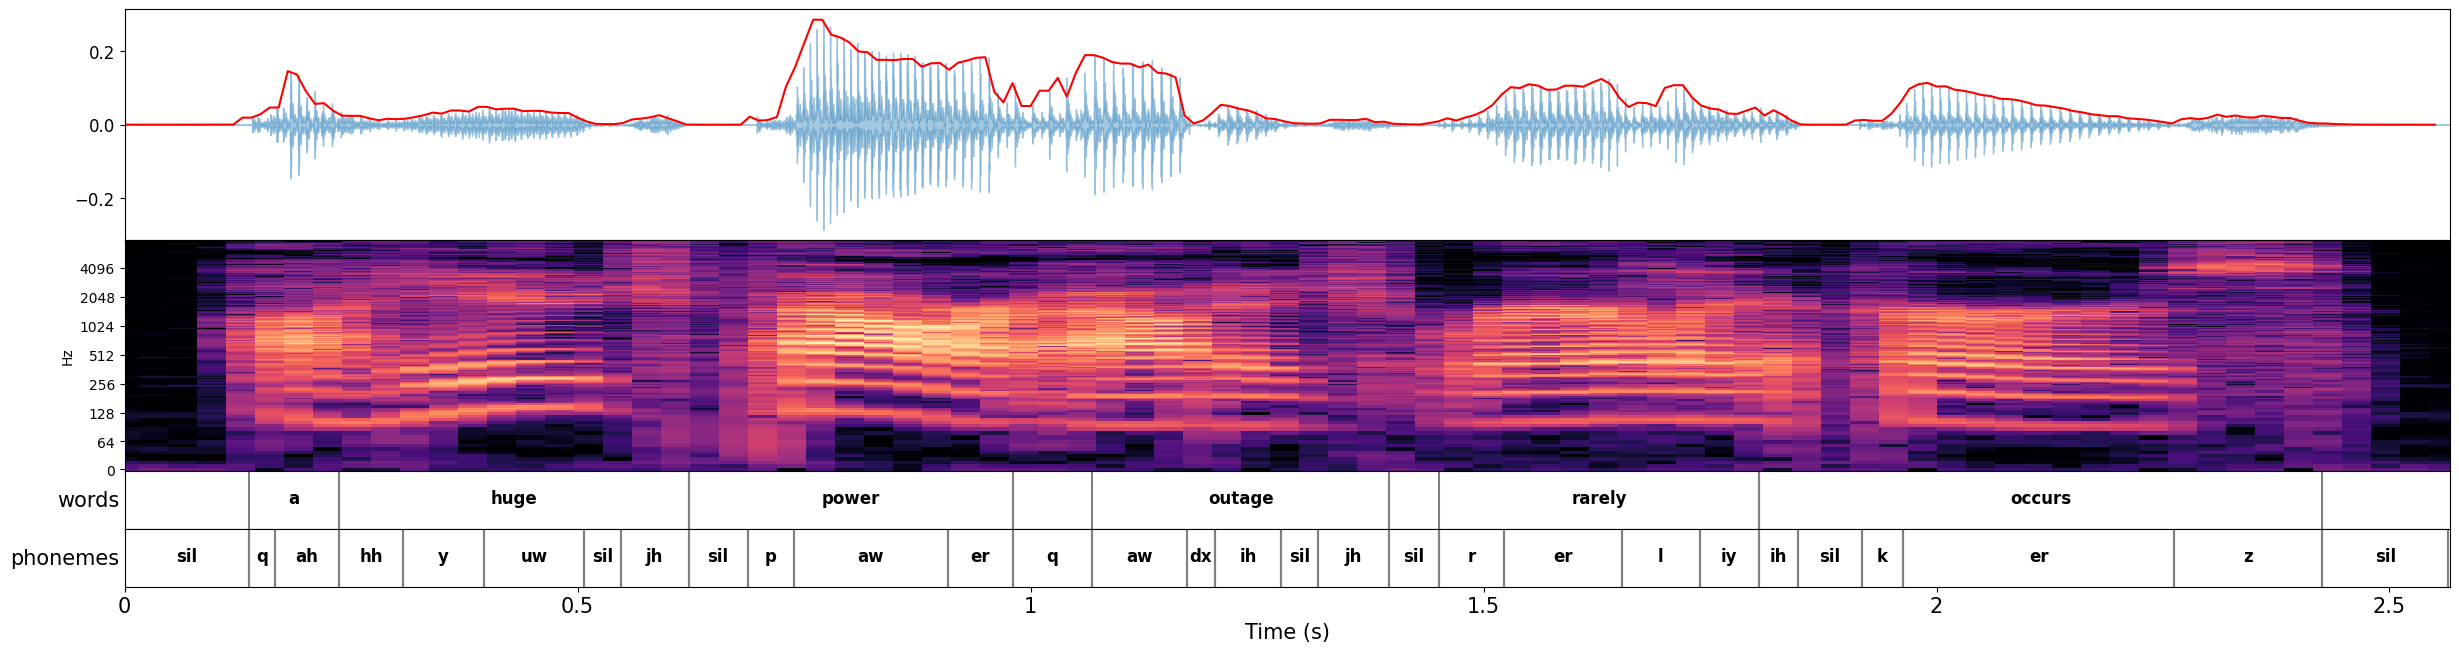

In [16]:
# Select a data item you want to examine (different from 0)
item_index = 0

data = timit_subset['train'][item_index]
# Retrieve the waveform from the data
raw_waveform = data['audio']['array']

# Sampling frequency
sampling_rate = data['audio']['sampling_rate'] # YOUR CODE HERE

# Listen to the audio
ipd.display(ipd.Audio(data=np.asarray(raw_waveform), autoplay=False, rate=sampling_rate))

# Print corresponding text
text = data['text']
print("Text:", text)

# Compute the amplitude envelope
envelope, envelope_timepoints = amplitude_envelope(raw_waveform, sampling_rate)

# Word annotations (note: times should be in seconds!)
words = data['word_detail']['utterance']
word_start_times = [t / sampling_rate for t in data['word_detail']['start']]
word_end_times = [t / sampling_rate for t in data['word_detail']['stop']]

# Phoneme annotations (note: times should be in seconds!)
phonemes = data['phonemic_detail']['utterance']
phoneme_start_times = [t / sampling_rate for t in data['phonemic_detail']['start']]
phoneme_end_times = [t / sampling_rate for t in data['phonemic_detail']['stop']]

plot_audio_annotations(raw_waveform, envelope, envelope_timepoints, word_start_times, word_end_times, words, phoneme_start_times, phoneme_end_times, phonemes, sampling_rate)

## The Wav2Vec2 Model

The Wav2Vec2 model was proposed in [wav2vec 2.0: A Framework for Self-Supervised Learning of Speech Representations](https://arxiv.org/abs/2006.11477) by Alexei Baevski, Henry Zhou, Abdelrahman Mohamed, Michael Auli.

The model takes raw audio waveforms as input and splits them into fixed-size frames of 25 milliseconds. During pre-training, some of these frames are masked and the model has to predict the correct speech unit for the masked position. In doing so, the model learns powerful speech representations in a self-supervised manner.

After pre-training, the model can be fine-tuned for several downstream tasks. We will investigate a model version that is fine-tuned for **Automatic Speech Recognition**, i.e. predicting written transcriptions that correspond to the spoken input. More specifically, the model was fine-tuned to predict a character for each of the 25ms-frames that we discussed above. These characters are then collapsed into well-formed transcriptions using [Connectionist Temporal Classification](https://distill.pub/2017/ctc/).





##### <input type="checkbox"/> <font color='blue'>**ToThink 2**</font>: The Wav2Vec2 Architecture

Read [this blogpost](https://jonathanbgn.com/2021/09/30/illustrated-wav2vec-2.html) about Wav2Vec2 and make sure you understand the different components inside the model.

##### <input type="checkbox"/> <font color='green'>**ToDo 3**</font>: The Wav2Vec2 Architecture

Load the model and processor by running the cell below. Examine the architecture carefully. What does the final `lm_head` component do?

Tip: you can also check the [model card](https://huggingface.co/facebook/wav2vec2-base-960h) and uploaded files for this model on HuggingFace.

In [17]:
# Load model and processor
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")

# Set model to evaluation mode
model.eval()
model.to(DEVICE)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.60k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

Wav2Vec2ForCTC(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder)

##### <input type="checkbox"/> <font color='red'>**ToSubmit 1 (ctd)**</font>: Generating a transcription
We will now generate a transcription for the TIMIT example you selected above with Wav2Vec2. Complete the function for transcribing audio below and include the generated transcription in your report. Are there any mistakes?

In [18]:
def transcribe_audio(audio_waveforms, sampling_rate, model=model, processor=processor):
  """
  Returns a list of transcriptions (text strings) for a list of audio waveforms.
  """
  # preprocess audio
  inputs = processor(audio_waveforms, sampling_rate=sampling_rate, return_tensors="pt", padding=True).input_values.to(DEVICE)

  # retrieve model logits
  logits = model(inputs).logits# YOUR CODE HERE

  # find the predicted character ids and decode
  predicted_ids = torch.argmax(logits, dim=-1)
  transcription = processor.batch_decode(predicted_ids)

  return transcription

# make sure your function works for a list of waveforms (even though we pass only a single one here)
audio_waveforms = [raw_waveform]
transcribe_audio(audio_waveforms, sampling_rate)

['A HUGE POWER OUTAGE RARELY OCCURS']

##  Evaluating model transcriptions with WER and CER

Once we are able to obtain a transcription for an audio segment from the model, we would like to know how accurate that transcription is. To measure this, we use two different metrics: Word Error Rate (WER) and Character Error Rate (CER). We use these to measure what proportion of the words (or characters) were not correctly transcribed. The word error rate is defined as:

$$WER = \frac{\text{Substitutions} + \text{Insertions} + \text{Deletions}}{\text{Total number of words}}$$

Where
*   **Substitutions** indicates the number of words in the audio which were substituted with another word in the transcript
*   **Insertion** indicates how many words which do not appear in the audio do appear in the transcript
*   **Deletions** indicates how many words are in the audio but do not appear in the transcription
*   **Total number of words** refers to the number of words in the *correct* transcription

CER is defined in the same way, but on a character level instead of a word level.

We will use implementations of the CER and WER metrics from the [jiwer](https://pypi.org/project/jiwer/) library.

##### <input type="checkbox"/> <font color='green'>**ToDo 4**</font>: Exploring CER and WER with a toy example

Familiarize yourself with WER and CER and their corresponding jiwer functions. Below is a toy example. What changes to `transcribed_text` make WER vs. CER go up or down?

In [25]:
correct_text = 'The quick brown fox jumps over the lazy dog.'
transcribed_text = 'the green brown Fox jum ps ova th lazy dog'

print(wer(correct_text, transcribed_text))
print(cer(correct_text, transcribed_text))

print("\n Word-level analysis")
out_words = jiwer.process_words(correct_text, transcribed_text)
print(jiwer.visualize_alignment(out_words, show_measures=False))

print("\n Character-level analysis")
out_char = jiwer.process_characters(correct_text, transcribed_text)
print(jiwer.visualize_alignment(out_char, show_measures=False))

1.0
0.3409090909090909

 Word-level analysis
sentence 1
REF: The quick brown *** fox jumps over the lazy *** dog.
HYP: the green brown Fox jum    ps  ova  th lazy dog  yeh
       S     S         I   S     S    S   S        I    S


 Character-level analysis
sentence 1
REF: The quick brown fox jum*ps over the lazy dog***.
HYP: the green brown Fox jum ps ova* th* lazy dog yeh
     S   SSSSS       S      I     SD   D         IIIS



It is now time to apply these evaluation metrics to some generated model transcripts. For this purpose, we'll take an even smaller sample of our TIMIT subset to evaluate the recorded sentences for only two speakers (our `speaker_subset`).

In [26]:
# Create a smaller subset of only two speakers
speaker_ids = list(np.unique(timit_subset['train']['speaker_id']))
speaker_subset = [speaker_ids[0], speaker_ids[-1]]
print('Speakers in subset:', speaker_subset)
timit_speaker_subset = timit_subset['train'].filter(lambda x: x["speaker_id"] in speaker_subset)

# Generate transcriptions for all sentences recorded by these speakers
model_transcriptions = {speaker_id: [] for speaker_id in speaker_subset}
correct_transcriptions = {speaker_id: [] for speaker_id in speaker_subset}
for speaker_id in speaker_subset:
  speaker_sentences = timit_speaker_subset.filter(lambda x: x["speaker_id"] == speaker_id)
  audio_waveforms = [a['array'] for a in speaker_sentences['audio']]
  correct_transcriptions[speaker_id] = speaker_sentences['text']
  model_transcriptions[speaker_id] = transcribe_audio(audio_waveforms, 16000)

print('MODEL TRANSCRIPTIONS:\n', model_transcriptions)
print('CORRECT TRANSCRIPTIONS:\n', correct_transcriptions)

Speakers in subset: [np.str_('FBCG1'), np.str_('MZMB0')]


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

MODEL TRANSCRIPTIONS:
 {np.str_('FBCG1'): ['CAN THE AGENCY OVERTHROW ALIEN FORCES', 'THE TRIUMPHANT WARRIOR EXHIBITED NAIVE HEROISM', 'ACCORDING TO MY INTERPRETATION OF THE PROBLEM TWO LINES MUST BE PERPENDICULAR', 'GOOD SERVICE SHOULD BE REWARDED BY BIG TIPS', 'SUBURBAN HOUSEWIVES OFTEN SUFFER FROM THE GAB HABIT'], np.str_('MZMB0'): ['WITHDRAW ONLY AS MUCH MONEY AS YOU NEED', 'BUYING A THOROUGHBRED HORSE REQUIRES INTUITION AND EXPERTACE', 'HISPANIC CASTUMES ARE QUITE COLORFUL', 'DIANE MAY SPLURGE AND BUY A TURQUOIS NECKLACE', 'THOMAS THINKS A LARGER CLAMP SOLVES THE PROBLEM']}
CORRECT TRANSCRIPTIONS:
 {np.str_('FBCG1'): ['Can the agency overthrow alien forces?', 'The triumphant warrior exhibited naive heroism.', 'According to my interpretation of the problem, two lines must be perpendicular.', 'Good service should be rewarded by big tips.', 'Suburban housewives often suffer from the gab habit.'], np.str_('MZMB0'): ['Withdraw only as much money as you need.', 'Buying a thoroughbred hor

You may have noticed that the formatting of the correct transcriptions does not correspond with the output of the model (the [Wav2Vec2 output vocabulary](https://huggingface.co/facebook/wav2vec2-base-960h/blob/main/vocab.json) does not include lowercase characters or punctuation marks).

To obtain fair error metrics, we make the formatting match:

In [27]:
formatted_correct_transcriptions = {}
for speaker in correct_transcriptions.keys():
    formatted_correct_transcriptions[speaker] = []
    for transcription in correct_transcriptions[speaker]:
        # make uppercase and remove punctuation (except for ')
        formatted_correct_transcriptions[speaker].append(transcription.upper().translate(str.maketrans('', '', string.punctuation.replace("'", ""))))

print('MODEL TRANSCRIPTIONS:\n', model_transcriptions)
print('CORRECT TRANSCRIPTIONS:\n', formatted_correct_transcriptions)

MODEL TRANSCRIPTIONS:
 {np.str_('FBCG1'): ['CAN THE AGENCY OVERTHROW ALIEN FORCES', 'THE TRIUMPHANT WARRIOR EXHIBITED NAIVE HEROISM', 'ACCORDING TO MY INTERPRETATION OF THE PROBLEM TWO LINES MUST BE PERPENDICULAR', 'GOOD SERVICE SHOULD BE REWARDED BY BIG TIPS', 'SUBURBAN HOUSEWIVES OFTEN SUFFER FROM THE GAB HABIT'], np.str_('MZMB0'): ['WITHDRAW ONLY AS MUCH MONEY AS YOU NEED', 'BUYING A THOROUGHBRED HORSE REQUIRES INTUITION AND EXPERTACE', 'HISPANIC CASTUMES ARE QUITE COLORFUL', 'DIANE MAY SPLURGE AND BUY A TURQUOIS NECKLACE', 'THOMAS THINKS A LARGER CLAMP SOLVES THE PROBLEM']}
CORRECT TRANSCRIPTIONS:
 {np.str_('FBCG1'): ['CAN THE AGENCY OVERTHROW ALIEN FORCES', 'THE TRIUMPHANT WARRIOR EXHIBITED NAIVE HEROISM', 'ACCORDING TO MY INTERPRETATION OF THE PROBLEM TWO LINES MUST BE PERPENDICULAR', 'GOOD SERVICE SHOULD BE REWARDED BY BIG TIPS', 'SUBURBAN HOUSEWIVES OFTEN SUFFER FROM THE GAB HABIT'], np.str_('MZMB0'): ['WITHDRAW ONLY AS MUCH MONEY AS YOU NEED', 'BUYING A THOROUGHBRED HORSE REQU

##### <input type="checkbox"/> <font color='green'>**ToDo 5**</font>: WER and CER on the `speaker_subset`

Compute the WER and CER for each of the transcripts you obtained using the model.

In [31]:
# YOUR CODE HERE
for speaker in model_transcriptions.keys():
  print(f'speaker {speaker}')
  for model_transcription, correct_transcription in zip(model_transcriptions[speaker], formatted_correct_transcriptions[speaker]):
    print('WER:', wer(correct_transcription, model_transcription))
    print('CER:', cer(correct_transcription, model_transcription))

speaker FBCG1
WER: 0.0
CER: 0.0
WER: 0.0
CER: 0.0
WER: 0.0
CER: 0.0
WER: 0.0
CER: 0.0
WER: 0.0
CER: 0.0
speaker MZMB0
WER: 0.0
CER: 0.0
WER: 0.125
CER: 0.03333333333333333
WER: 0.2
CER: 0.027777777777777776
WER: 0.125
CER: 0.021739130434782608
WER: 0.0
CER: 0.0


##### <input type="checkbox"/> <font color='blue'><b>ToThink 3</b></font>: Inspecting (mis)transcriptions

Inspect a few of the mistranscriptions and listen to the corresponding audio. Can you think of a reason for these mistakes?

In [43]:
item_index = 1
print(timit_speaker_subset[item_index]['speaker_id'], timit_speaker_subset[item_index]['text'])
print(transcribe_audio(timit_speaker_subset[item_index]['audio']['array'], 16000))
ipd.display(ipd.Audio(timit_speaker_subset[item_index]['audio']['array'], rate=timit_speaker_subset[item_index]['audio']['sampling_rate']))

MZMB0 Buying a thoroughbred horse requires intuition and expertise.
['BUYING A THOROUGHBRED HORSE REQUIRES INTUITION AND EXPERTACE']


## Effect of noise

Up until now, we have been only transcribing high-quality audio. This is not always the case, since there may be some noise in the recordings we want to transcribe. Ideally, ASR systems are robust to noise, so it is useful to identify what noise levels cause problems for transcriptions.

We can simulate noise by adding some gaussian noise to recordings from the TIMIT dataset. We will use a "noise factor" parameter to determine how much noise (in units of the standard deviation of the audio) we will add:

##### <input type="checkbox"/> <font color='green'><b>ToDo 6</b></font>: Adding noise to audio

Create a function to add gaussian noise to an audio array. The standard deviation of the noise should be ```noise_factor```times the standard deviation of the audio

In [46]:
def add_noise(audio_array, noise_factor):
    # YOUR CODE HERE
    noised_audio = audio_array + np.random.normal(0, noise_factor * np.std(audio_array), audio_array.shape)

    return noised_audio

sample_audio = np.asarray(raw_waveform)
noised_audio = add_noise(sample_audio,1)
ipd.display(ipd.Audio(noised_audio, rate=16000))

To analyze how the transcription quality changes when the audio is noisy, we'll create transcriptions for audio with different levels of noise, and then evaluate them.

Note: Computing the results for each individual transcription and averaging them will give slightly different results from considering the whole set of transcriptions at once when counting insertions/deletions/substitutions and total number of words. In the function below, we use the latter.

In [61]:
def noisy_wer_cer(noise_factor):
    noisy_model_transcriptions = {speaker_id: [] for speaker_id in speaker_subset}

    # Generated transcriptions
    for speaker_id in speaker_subset:
        speaker_sentences = timit_speaker_subset.filter(lambda x: x["speaker_id"] == speaker_id)
        audio_waveforms = [add_noise(a['array'], noise_factor) for a in speaker_sentences['audio']]
        noisy_model_transcriptions[speaker_id] = transcribe_audio(audio_waveforms, 16000)

    # Evaluation
    all_correct = sum(formatted_correct_transcriptions.values(), [])
    all_model = sum(noisy_model_transcriptions.values(), [])
    return wer(all_correct, all_model), cer(all_correct, all_model)

random.seed(0)
np.random.seed(0)
avg_wer, avg_cer = noisy_wer_cer(0.25)

print('Average WER: ', avg_wer)
print('Average CER: ', avg_cer)

Average WER:  0.2597402597402597
Average CER:  0.0995850622406639


##### <input type="checkbox"/> <font color='red'><b>ToSubmit 2</b></font>: WER and CER over noisy audio

Compute the average WER and CER for different noise_factor values ```noise_factor = [0, 0.2, 0.4, 0.6, 0.8, 1]```, over all transcriptions from the `speaker_subset`. Save them to vectors called ```noisy_wer``` and ```noisy_cer```, and use the code below to plot them. Add the plot to your submission, together with a brief (max. 2 sentence) description of the patterns you observe.

In [52]:
noise_factors = [0, 0.2, 0.4, 0.6, 0.8, 1]

# YOUR CODE HERE
noisy_wer, noisy_cer = [], []
for noise_factor in noise_factors:
  avg_wer, avg_cer = noisy_wer_cer(noise_factor)
  noisy_wer.append(avg_wer)
  noisy_cer.append(avg_cer)


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

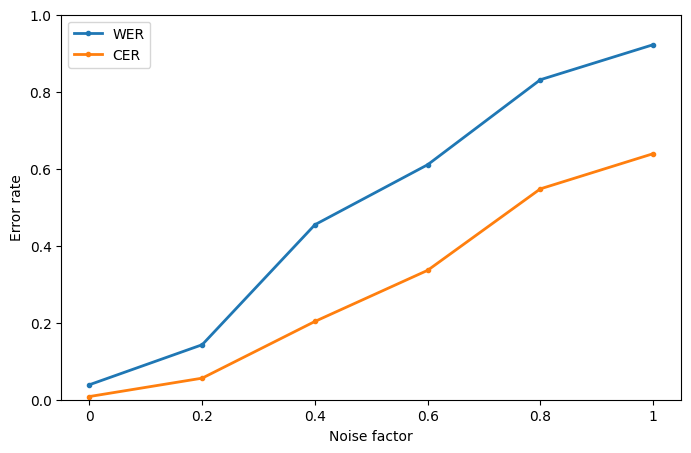

In [53]:
fig, axes = plt.subplots(1, 1, figsize=(8,5))

axes.plot(noisy_wer, 'o-', lw=2, markersize=3, label='WER')
axes.plot(noisy_cer, 'o-', lw=2, markersize=3, label='CER')

axes.legend()
axes.set_ylim(0,1)
axes.set_xlabel("Noise factor")
axes.set_ylabel("Error rate")
axes.set_xticks(range(len(noise_factors)), noise_factors, minor=False)

plt.show()

## Inspecting orthographic information over model layers using the _CTC lens_

We have been looking at the transcriptions the model produces as its output, but we might want to know where in the model information associated with particular transcriptions arises. For a first rough probe of where orthography becomes encoded across layers of Wav2Vec2, we can use the model's CTC head, which is normally applied to the last layer, as a 'lens' to inspect hidden states of earlier layers (a 'CTC lens').

Let's test this on a single transcription:

In [110]:
# CTC lens
def CTC_lens_transcription(layer_hidden_states, model=model):
  layer_logits = model.lm_head(layer_hidden_states)
  layer_pred_ids = torch.argmax(layer_logits, dim=-1)
  layer_transcription = processor.batch_decode(layer_pred_ids)
  return layer_transcription

# an example sentence
example = timit_subset['train'][0]
correct_transcription = example['text']
print(correct_transcription)

# get all hidden states for this sentence
inputs = processor(example['audio']['array'], sampling_rate=16000, return_tensors="pt", padding=True).input_values.to(DEVICE)
with torch.no_grad():
  out = model(inputs, output_hidden_states=True)

A huge power outage rarely occurs.


In [111]:
for layer in range(model.config.num_hidden_layers + 1):
  print(f'layer {layer}')
  print(out.hidden_states[layer].shape)
  layer_transcription = CTC_lens_transcription(out.hidden_states[layer])
  print(layer_transcription)

layer 0
torch.Size([1, 128, 768])
["KQ<s>WFXNH ZLXVYI<unk>AY<unk>HYF</s>H MO</s>MF</s>FRZRAO</s>F</s>NBAZ</s>'<unk>Y</s>K</s> LRXBLXINZX'</s>TC</s>RBRBR'RX<unk>JSYUK<s>F"]
layer 1
torch.Size([1, 128, 768])
['HIIYEYD HUGPHMO</s>OLARARAOBFNHAIDHI</s> RANLAI AI</s>GDCRRESISIKON']
layer 2
torch.Size([1, 128, 768])
['OHHYEDS TPHOLR AOATDTIDHI RATLLAI AICGCRIRRESHO']
layer 3
torch.Size([1, 128, 768])
['LAYEDSI TPHOR PAOTDAIDH RL</s>I AEGCRSH']
layer 4
torch.Size([1, 128, 768])
['FYEH PHO</s>OUPR </s>JUTDBID RLIYEGCRSTF']
layer 5
torch.Size([1, 128, 768])
['GGYUH PHO<s>R AUTDIAH R RLYAXCRS G G']
layer 6
torch.Size([1, 128, 768])
['DDA HED PHOAR AOUTDAD RARLIYAECRS D D']
layer 7
torch.Size([1, 128, 768])
['POAR OWTDA RARLY ACIRS']
layer 8
torch.Size([1, 128, 768])
['A HU POR OWTAGE AR LY ACRS']
layer 9
torch.Size([1, 128, 768])
['A HUGE POWER OTAGE RARELY OCURS']
layer 10
torch.Size([1, 128, 768])
['A HUGE POWER OUTAGE RARELY OCCURS']
layer 11
torch.Size([1, 128, 768])
['A HUGE POWER OUTAGE RA

##### <input type="checkbox"/> <font color='blue'><b>ToThink 4</b></font>: Inspecting layerwise transcriptions

Does the CTC head produce legible transcriptions only for the output layer, or also for intermediate layers? What does this mean?

We can use the evaluation metrics introduced earlier (WER and CER) to see how the quality of the transcriptions changes through the layers. To do that, we will extract the hidden states for all layers for different recordings, and compute the WER and CER for all examples for each layer.

##### <input type="checkbox"/> <font color='green'><b>ToDo 7</b></font>: Computing WER and CER on the layerwise transcriptions

Fill in the code below to extract layerwise transcriptions **for all sentences in the `speaker_subset`** and measure how the average WER and CER change depending on the layer we extract the transcription from.

In [66]:
from collections import defaultdict

layer_wer = []
layer_cer = []

layer_transcript_dict = defaultdict(lambda: {'correct': [], 'predicted': []})

# YOUR CODE HERE
for speaker_id in speaker_subset:
  speaker_sentences = timit_speaker_subset.filter(lambda x: x["speaker_id"] == speaker_id)
  audio_waveforms = [a['array'] for a in speaker_sentences['audio']]
  correct_transcriptions = formatted_correct_transcriptions[speaker_id]

  inputs = processor(audio_waveforms, sampling_rate=16000, return_tensors="pt", padding=True).input_values.to(DEVICE)
  with torch.no_grad():
    out = model(inputs, output_hidden_states=True)

  for layer in range(model.config.num_hidden_layers + 1):
    layer_transcription = CTC_lens_transcription(out.hidden_states[layer])
    layer_transcript_dict[layer]['correct'].extend(correct_transcriptions)
    layer_transcript_dict[layer]['predicted'].extend(layer_transcription)

for layer in range(model.config.num_hidden_layers + 1):
  layer_wer.append(wer(layer_transcript_dict[layer]['correct'], layer_transcript_dict[layer]['predicted']))
  layer_cer.append(cer(layer_transcript_dict[layer]['correct'], layer_transcript_dict[layer]['predicted']))



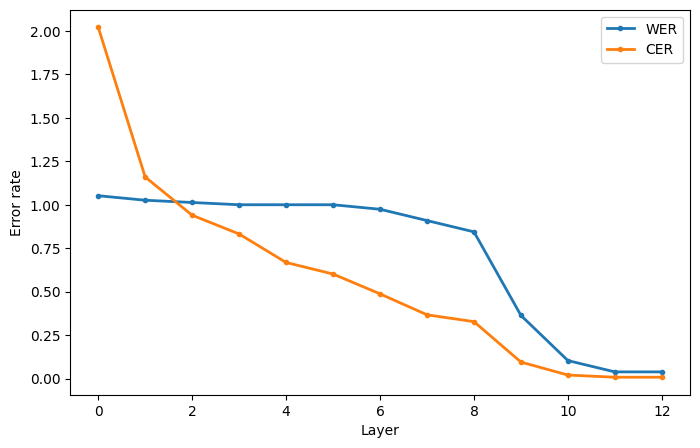

In [67]:
fig, axes = plt.subplots(1, 1, figsize=(8,5))

axes.plot(layer_wer, 'o-', lw=2, markersize=3, label='WER')
axes.plot(layer_cer, 'o-', lw=2, markersize=3, label='CER')

axes.legend()
axes.set_xlabel("Layer")
axes.set_ylabel("Error rate")

plt.show()

##### <input type="checkbox"/> <font color='red'><b>ToSubmit 3</b></font>: Metrics for orthographic decoding accuracy

Do you think the WER and CER metrics are equally suitable to examine the layerwise encoding of orthographic information in Wav2Vec2, and why? Add the plot with layerwise results over the `speaker_subset` to your report, with a brief (1 sentence) description.

## Training probes on hidden states

### Phoneme probing classifiers

With the CTC-lens we can create layerwise measures of orthographic information, which the ASR-finetuned version of Wav2Vec2 is trained to encode. However, we may also want to measure the encoding of other types of information which the model is not explicitly trained for, such as phonemic distinctions.

To do this we can train regression models to predict our features of interest from the hidden states of the model. Here, we will experiment with logistic regression probes to predict phoneme identity. We will first extract a corpus of hidden states to train our probes on.

Concretely, we will perform the following steps to achieve this:

1.  **Prepare input**: Retrieve the raw waveforms (i.e. audio arrays) from the TIMIT corpus and process them using the Wav2Vec2 processor.
2.  **Forward pass**: Pass the waveforms through the model with ```output_hidden_states``` set to True.
3. **Save hidden states**: Save the hidden states in a dictionary, which is organized by Transformer layer index and waveform index. Each waveform will have list of frame-level hidden states.
4. **Sort hidden states per phoneme class**: Sort the hidden states by phoneme class using the time-aligned transcriptions from TIMIT.


In [68]:
def extract_hidden_states(model, processor, inputs, num_layers):
    '''
    Extract hidden states from Wav2Vec 2.0 transformer layers.
    :param model: Wav2Vec 2.0 model
    :param processor: Wav2Vec 2.0 processor
    :param inputs: list of TIMIT instances (i.e. timit['train'] or timit['test'])
    :return: dictionary containing frame-level hidden states saved per transformer layer and per waveform
    '''

    # Get waveforms
    waveforms = [input["audio"]["array"] for input in inputs]

    # Here we will save all frame-level hidden states, sorted by layer and waveform
    frame_states = {
        layer_idx: {
            waveform_idx: []
            for waveform_idx in range(len(waveforms))
        }
        for layer_idx in range(num_layers)
    }

    for waveform_idx, waveform in enumerate(waveforms):

        print(f'Extracting hidden states from waveform {waveform_idx} out of {len(waveforms)} waveforms...')

        # Process waveform using the Wav2Vec2 processor
        processed_input = processor(waveform, sampling_rate=16000, return_tensors="pt", padding='longest').input_values

        with torch.no_grad():
            input_tensor = torch.tensor(processed_input, device=DEVICE)

            # forward pass
            model_output = model(input_tensor, output_hidden_states=True, output_attentions=False)

            # get all hidden outputs
            transformer_layers = model_output.hidden_states

        # Save frame-level hidden states, organized by layer and waveform
        for layer_idx, layer in enumerate(transformer_layers):
            for waveform in layer:
              for frame in waveform:
                  frame_states[layer_idx][waveform_idx].append(frame.cpu())

    return frame_states

Function to sort the hidden states by phoneme class using the time-aligned transcriptions from TIMIT:

In [69]:
def sort_states_per_phoneme(data, frame_states, num_layers):

    frame_states_per_phoneme = {
        layer_idx: defaultdict(list)
        for layer_idx in range(num_layers)
    }

    for layer_idx, layer in frame_states.items():

        for waveform_idx, waveform in layer.items():

            # retrieve phoneme annotation for the current waveform
            phonemes = data[waveform_idx]["phonemic_detail"]
            phoneme_indeces = defaultdict(list)

            for start, stop, phoneme in zip(phonemes['start'], phonemes['stop'], phonemes['utterance']):

                # divide start and stop point by sample rate (16000 hz) and frame length (0.020 sec)
                start_index = math.floor((start / 16000) / 0.020)
                stop_index = math.ceil((stop / 16000) / 0.020)

                phoneme_indeces[phoneme].extend(range(start_index, stop_index))

            # find hidden states corresponding to phoneme indeces and save them per layer and per phoneme
            for phoneme, indeces in phoneme_indeces.items():
                phoneme_states = [waveform[idx] for idx in indeces if idx < len(waveform)]
                frame_states_per_phoneme[layer_idx][phoneme].extend(phoneme_states)

    return frame_states_per_phoneme

##### <input type="checkbox"/> <font color='green'>**ToDo 8**</font>: Retrieving model hidden states

Extract the hidden states for training and testing our probes (this might take some time):

In [70]:
import math
from collections import defaultdict

# number of hidden layers of the transformer model + the input embeddings
num_layers = model.config.num_hidden_layers + 1

train_set = timit_subset['train']
test_set = timit_subset['test']
# Extract frame-level hidden states for training and testing the probes (make sure you pass the data subset)
frame_states_train = extract_hidden_states(model, processor, train_set, num_layers)
frame_states_test = extract_hidden_states(model, processor, test_set, num_layers)

# Sort the hidden states by phoneme (make sure you pass the data subset)
phoneme_states_train = sort_states_per_phoneme(train_set, frame_states_train, num_layers)
phoneme_states_test = sort_states_per_phoneme(test_set, frame_states_test, num_layers)

Extracting hidden states from waveform 0 out of 300 waveforms...
Extracting hidden states from waveform 1 out of 300 waveforms...
Extracting hidden states from waveform 2 out of 300 waveforms...
Extracting hidden states from waveform 3 out of 300 waveforms...
Extracting hidden states from waveform 4 out of 300 waveforms...


<ipython-input-68-551859219>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_tensor = torch.tensor(processed_input, device=DEVICE)


Extracting hidden states from waveform 5 out of 300 waveforms...
Extracting hidden states from waveform 6 out of 300 waveforms...
Extracting hidden states from waveform 7 out of 300 waveforms...
Extracting hidden states from waveform 8 out of 300 waveforms...
Extracting hidden states from waveform 9 out of 300 waveforms...
Extracting hidden states from waveform 10 out of 300 waveforms...
Extracting hidden states from waveform 11 out of 300 waveforms...
Extracting hidden states from waveform 12 out of 300 waveforms...
Extracting hidden states from waveform 13 out of 300 waveforms...
Extracting hidden states from waveform 14 out of 300 waveforms...
Extracting hidden states from waveform 15 out of 300 waveforms...
Extracting hidden states from waveform 16 out of 300 waveforms...
Extracting hidden states from waveform 17 out of 300 waveforms...
Extracting hidden states from waveform 18 out of 300 waveforms...
Extracting hidden states from waveform 19 out of 300 waveforms...
Extracting hidd

It is now time to train and evaluate our probes. We will define a probing classifier for each layer of the Wav2Vec2 model to see how phoneme information is represented across layers. We will be using Logistic Regression as our classification models (but feel free to experiment with other classifiers such as SVM).

In [71]:
warnings.filterwarnings("ignore")

# Define layer-wise probes, to be trained and tested on frame-level Wav2Vec2 embeddings
layer_probes = {
    layer_idx: LogisticRegression(solver="liblinear", penalty="l2", max_iter=10)
    for layer_idx in range(num_layers)
}

Helper functions for putting the data in the right format for Logistic Regression models, and for balancing the data:

In [72]:
def phoneme_data_loader(hidden_state_dict, layer_idx, target_phonemes=None):
    X = []
    y = []

    for phoneme, hidden_state_list in hidden_state_dict[layer_idx].items():
        for i in hidden_state_list:
            if i != None and phoneme != 'q':
                if target_phonemes == None:
                    X.append(np.array(i))
                    y.append(phoneme)
                else:
                    if phoneme in target_phonemes:
                        X.append(np.array(i))
                        y.append(phoneme)

    return X, y

def balance_classes(X_instances, y_labels):

    balanced_data_X = []
    balanced_data_y = []

    class_distribution = Counter(y_labels)
    num_instances_per_class = min(class_distribution.values())

    for label in class_distribution.keys():

        i = 1
        instances = []
        labels = []

        for x, y in zip(X_instances, y_labels):
            if y == label:
                instances.append(x)
                labels.append(y)
                if i == num_instances_per_class:
                    balanced_data_X.extend(instances)
                    balanced_data_y.extend(labels)
                    break
                i += 1

    return balanced_data_X, balanced_data_y

##### <input type="checkbox"/> <font color='green'>**ToDo 9**</font>: Training & evaluating probes

Train and evaluate the probing classifier for each layer (this will take some time). Examine the difference in probing accuracy when predicting different categories of phonemes (i.e. stops, fricatives, nasals, glides, vowels). The different categories are explained [here](http://www.ello.uos.de/field.php/PhoneticsandPhonology/MannerOfArticulation).

In [73]:
phoneme_dict = {
    'stops': ['p', 't', 'k', 'b', 'd', 'g'],
    'fricatives': ['f', 'v', 'th', 'dh', 's', 'z', 'sh'],
    'nasals': ['m', 'n', 'ng'],
    'approximants': ['l', 'w', 'y', 'hh'],
    'vowels': ['aa', 'ow', 'iy', 'eh', 'uh']
}

# Save layer-wise accuracies for each phoneme category
accs_per_category = []

for phoneme_category, target_phonemes in phoneme_dict.items():

  print(f"Training layer-wise probes to predict {phoneme_category}...")
  accs = []

  # Train and test an individual probe for each layer
  for layer_idx in range(num_layers):

    # Put train data in the right format for our probing classifier + balance classes
    train_X, train_y = phoneme_data_loader(phoneme_states_train, layer_idx, target_phonemes=target_phonemes)
    train_X, train_y = balance_classes(train_X, train_y)

    if layer_idx == 0:
      print("Balanced class distribution TRAIN:", Counter(train_y))

    # Train model
    layer_probes[layer_idx].fit(train_X, train_y)

    # Put test data in the right format for our probing classifier + balance classes
    test_X, test_y = phoneme_data_loader(phoneme_states_test, layer_idx, target_phonemes=target_phonemes)
    test_X, test_y = balance_classes(test_X, test_y)

    if layer_idx == 0:
      print("Balanced class distribution TEST:", Counter(test_y))

    # Predict
    test_pred = layer_probes[layer_idx].predict(test_X)
    test_acc = accuracy_score(test_y, test_pred)
    print(f'Accuracy for layer {layer_idx}:', test_acc)
    accs.append(test_acc)

  accs_per_category.append(accs)

Training layer-wise probes to predict stops...
Balanced class distribution TRAIN: Counter({'p': 283, 'k': 283, 'g': 283, 'd': 283, 't': 283, 'b': 283})
Balanced class distribution TEST: Counter({'t': 108, 'b': 108, 'k': 108, 'g': 108, 'd': 108, 'p': 108})
Accuracy for layer 0: 0.7299382716049383
Accuracy for layer 1: 0.7654320987654321
Accuracy for layer 2: 0.8271604938271605
Accuracy for layer 3: 0.8796296296296297
Accuracy for layer 4: 0.9135802469135802
Accuracy for layer 5: 0.9490740740740741
Accuracy for layer 6: 0.9660493827160493
Accuracy for layer 7: 0.9660493827160493
Accuracy for layer 8: 0.9675925925925926
Accuracy for layer 9: 0.9675925925925926
Accuracy for layer 10: 0.9660493827160493
Accuracy for layer 11: 0.9552469135802469
Accuracy for layer 12: 0.9320987654320988
Training layer-wise probes to predict fricatives...
Balanced class distribution TRAIN: Counter({'z': 304, 's': 304, 'v': 304, 'sh': 304, 'dh': 304, 'f': 304, 'th': 304})
Balanced class distribution TEST: Coun

##### <input type="checkbox"/> <font color='green'>**ToDo 10**</font>: Plotting layerwise phoneme probing accuracies

Plot the layer-wise accuracies per phoneme category.

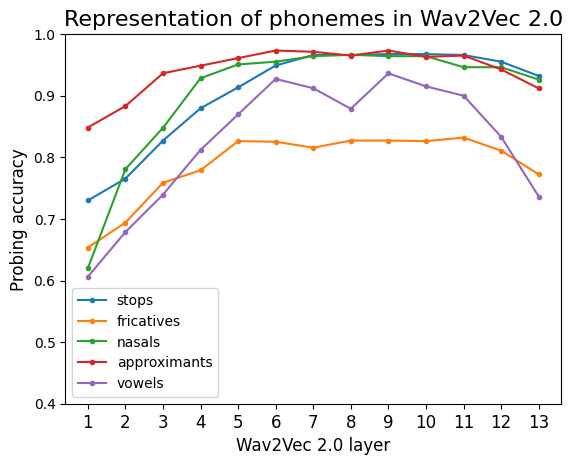

In [74]:
for accs in accs_per_category:

  # Plot layer-wise probing accuracy per phoneme category
  plt.plot(range(num_layers), accs, marker='.')
  plt.title(f'Representation of phonemes in Wav2Vec 2.0', fontsize=16)
  plt.xlabel('Wav2Vec 2.0 layer', fontsize=12)
  plt.xticks(range(num_layers), range(1, 14), fontsize=12)
  plt.ylabel('Probing accuracy', fontsize=12)
  plt.legend(list(phoneme_dict.keys()))
  plt.ylim((0.4, 1.0))

plt.show()

### Probing acoustic information

We can also train probes on simpler acoustic features, such as the amplitude envelope. The envelope is a continuous variable, so we can use simple linear regression probes instead of logistic regression.

##### <input type="checkbox"/> <font color='green'>**ToDo 11**</font>: Decoding amplitude envelope from model hidden states

Use the code below to train frame-wise probes decoding amplitude envelope values out of model hidden states. For evaluation, use the coefficient of determination ($R^2$) computed by the default sklearn [score](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression.score) function for linear regressions.

In [75]:
train_envelopes = {
    waveform_idx: amplitude_envelope(timit_subset['train'][waveform_idx]["audio"]["array"], sampling_rate=16000, window_length=400, hop_length=320)[0]
    for waveform_idx in range(len(timit_subset['train']))
    }
test_envelopes = {
    waveform_idx: amplitude_envelope(timit_subset['test'][waveform_idx]["audio"]["array"], sampling_rate=16000, window_length=400, hop_length=320)[0]
    for waveform_idx in range(len(timit_subset['test']))
    }

In [76]:
def envelope_data_loader(frame_states, envelopes, layer_idx):
  for wi, ae in envelopes.items():
    # if envelope & frame states differ in length (usually by 1, due to rounding differences),
    # we cut them to the same length here
    if ae.shape[0] != np.array(frame_states[layer_idx][wi]).shape[0]:
      min_size = np.min([ae.shape[0], np.array(frame_states[layer_idx][wi]).shape[0]])-1
      envelopes[wi] = ae[:min_size]
      frame_states[layer_idx][wi] = frame_states[layer_idx][wi][:min_size]
  X = np.concatenate(list(frame_states[layer_idx].values()))
  y = np.concatenate(list(envelopes.values()))
  return X, y

In [78]:
from tqdm import tqdm

envelope_probes = {
    layer: LinearRegression() for layer in range(num_layers)
}

envelope_probe_scores = []

# YOUR CODE HERE
for layer_idx in tqdm(range(num_layers)):
  train_X, train_y = envelope_data_loader(frame_states_train, train_envelopes, layer_idx)
  test_X, test_y = envelope_data_loader(frame_states_test, test_envelopes, layer_idx)

  envelope_probes[layer_idx].fit(train_X, train_y)

  test_score= envelope_probes[layer_idx].score(test_X, test_y)
  print(f'Score for layer {layer_idx}:', test_score)
  envelope_probe_scores.append(test_score)

  8%|▊         | 1/13 [00:04<00:48,  4.02s/it]

Score for layer 0: 0.7301689982414246


 15%|█▌        | 2/13 [00:05<00:29,  2.71s/it]

Score for layer 1: 0.7576634287834167


 23%|██▎       | 3/13 [00:07<00:23,  2.31s/it]

Score for layer 2: 0.7340990304946899


 31%|███       | 4/13 [00:09<00:19,  2.13s/it]

Score for layer 3: 0.7370411157608032


 38%|███▊      | 5/13 [00:11<00:16,  2.04s/it]

Score for layer 4: 0.698676586151123


 46%|████▌     | 6/13 [00:13<00:14,  2.12s/it]

Score for layer 5: 0.6633673906326294


 54%|█████▍    | 7/13 [00:15<00:12,  2.04s/it]

Score for layer 6: 0.606263279914856


 62%|██████▏   | 8/13 [00:17<00:09,  1.97s/it]

Score for layer 7: 0.5707412958145142


 69%|██████▉   | 9/13 [00:19<00:07,  1.91s/it]

Score for layer 8: 0.5265186429023743


 77%|███████▋  | 10/13 [00:20<00:05,  1.89s/it]

Score for layer 9: 0.5052152872085571


 85%|████████▍ | 11/13 [00:22<00:03,  1.87s/it]

Score for layer 10: 0.5125787258148193


 92%|█████████▏| 12/13 [00:25<00:02,  2.13s/it]

Score for layer 11: 0.46031463146209717


100%|██████████| 13/13 [00:27<00:00,  2.11s/it]

Score for layer 12: 0.38210564851760864


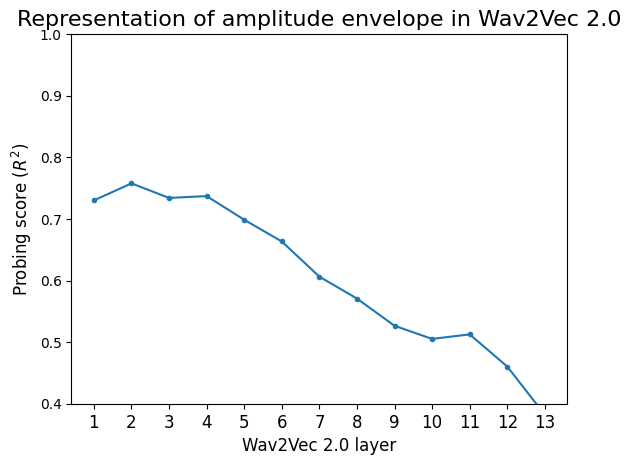

In [79]:
  # Plot layer-wise probing accuracy for amplitude envelope
  plt.plot(range(num_layers), envelope_probe_scores, marker='.')
  plt.title(f'Representation of amplitude envelope in Wav2Vec 2.0', fontsize=16)
  plt.xlabel('Wav2Vec 2.0 layer', fontsize=12)
  plt.xticks(range(num_layers), range(1, 14), fontsize=12)
  plt.ylabel('Probing score ($R^2$)', fontsize=12)
  plt.ylim(0.4, 1)
  plt.show()

## CTC-probing orthographic information

Finally, we'll compare the model's layerwise encoding of acoustic and phonemic information to the orthographic accuracy we can obtain by decoding transcriptions out of the model's hidden layers. Since we don't train the CTC lens, we can just evaluate the character error rate on our `timit_subset['test']` set.

##### <input type="checkbox"/> <font color='green'>**ToDo 12**</font>: Computing layerwise CER on the `timit_subset['test']` set
Compute the CER over model layers using the CTC-lens for layerwise transcriptions of all sentences in the `timit_subset['test']` set.

Hint: You can use the `frame_states_test` dictionary computed above, but you'll need to reshape the states stored in there into a `torch.Tensor` with the right dimensions to be read by the `CTC_lens_transcription` function.

In [124]:
correct_transcriptions = [data['text'] for data in timit_subset['test']]
formatted_correct_transcriptions = [transcription.upper().translate(str.maketrans('', '', string.punctuation.replace("'", ""))) for transcription in correct_transcriptions]
layerwise_transcriptions = {layer: [] for layer in range(num_layers)}
layerwise_cer = []
# torch.Size([5, 183, 768])

for layer_idx in tqdm(range(num_layers)):
  for cur_frame in frame_states_test[layer_idx].values():
    layerwise_transcriptions[layer_idx].extend(CTC_lens_transcription(torch.stack(cur_frame).unsqueeze(0).to(DEVICE)))

  layerwise_cer.append(cer(formatted_correct_transcriptions, layerwise_transcriptions[layer_idx]))

100%|██████████| 13/13 [00:01<00:00,  8.33it/s]


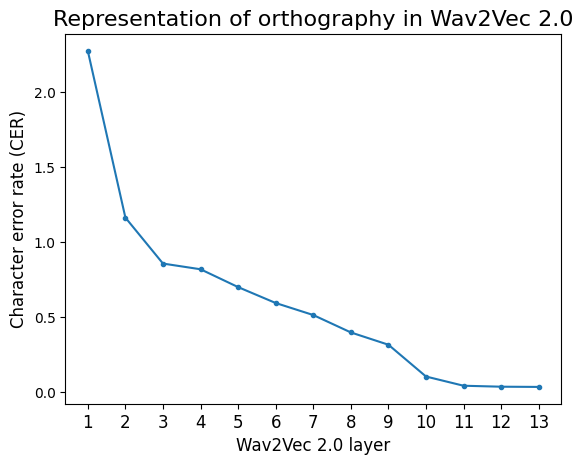

In [125]:
  # Plot layer-wise character error rate for test sentences
  plt.plot(range(num_layers), layerwise_cer, marker='.')
  plt.title(f'Representation of orthography in Wav2Vec 2.0', fontsize=16)
  plt.xlabel('Wav2Vec 2.0 layer', fontsize=12)
  plt.xticks(range(num_layers), range(1, 14), fontsize=12)
  plt.ylabel('Character error rate (CER)', fontsize=12)
  plt.show()

##### <input type="checkbox"/> <font color='red'>**ToSubmit 4**</font>: Comparing layerwise probing results

Submit the three plots of your probing results (evaluating on the `timit_subset['test']` set). Can you make sense of the observed pattern of layerwise results in terms of the processing mechanisms of the Wav2Vec2 architecture? And in terms of the model's training objective?

Include a brief caption describing differences in the layerwise representation of acoustic, phonemic and orthographic information in Wav2Vec2 and your explanation of this pattern.